In [1]:
import sys
sys.path.append("../")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGPooling, ASAPooling
from src import graph_dataset, graph_trainer
import os
from src import visual
import h5py

In [13]:
class GCN(nn.Module):
    def __init__(self, pool='SAG', ratio=0.4, class_num=10):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16, add_self_loops = True, normalize = True)
        self.conv2 = GCNConv(16, 32, add_self_loops = True, normalize = True)
        self.conv3 = GCNConv(32, 64, add_self_loops = True, normalize = True)
        self.pool1 = SAGPooling(in_channels=32, ratio=ratio)
        self.pool2 = SAGPooling(in_channels=64, ratio=ratio)
        self.conv4 = GCNConv(64, 32, add_self_loops = True, normalize = True)
        self.conv5 = GCNConv(32, 32, add_self_loops = True, normalize = True)
        self.conv6 = GCNConv(32, class_num, add_self_loops = True, normalize = True)
        
    def forward(self, x, edge_index, edge_attr):
        x = x.view(-1, 3)
        edge_index = edge_index.view(2, -1)
        edge_attr = edge_attr.view(-1)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        temp = self.pool1(x, edge_index, edge_attr)
        x, edge_index, edge_attr = temp[0], temp[1], temp[2]
        
        x = self.conv3(x, edge_index, edge_attr)
        x = F.relu(x)
        temp = self.pool2(x, edge_index, edge_attr)
        x, edge_index, edge_attr = temp[0], temp[1], temp[2]
        
        x = self.conv4(x, edge_index, edge_attr)
        x = F.relu(x)
        
        x = self.conv5(x, edge_index, edge_attr)
        x = F.relu(x)
        
        x = self.conv6(x, edge_index, edge_attr)
        x = F.relu(x)
        
        x = torch.max(x, dim=0, keepdim=True)[0]
        
        return F.log_softmax(x, dim=1)


In [106]:
import torch
import torch.utils.data as data
from sklearn import preprocessing
import h5py
import numpy as np
class GCNdata(data.Dataset):
    def __init__(self, paths, labels, aug):
        self.paths = paths
        le = preprocessing.LabelEncoder()
        self.labels = le.fit_transform(labels)
        self.dct = le.classes_
        self.aug = aug
        self.example = []
        
    def __getitem__(self, index):
        f = h5py.File(self.paths[index], 'r')
        edge_w = f['edge_weight'][:]
        edges = f['edges'][:]
        nodes = f['nodes'][:]
        edges = torch.tensor(edges, dtype = torch.long)
        
        if self.aug == 'strech':
            if len(self.example) == 0:
                self.example.append((nodes, nodes*100))
            nodes = nodes * 100
        
        if self.aug == 'shrink':
            if len(self.example) == 0:
                self.example.append((nodes, nodes*0.1))
            nodes = nodes * 0.1
            
        if self.aug == 'translate':
            if len(self.example) == 0:
                self.example.append((nodes, nodes+0.1))
            nodes = nodes + 0.1
            
        if self.aug == 'stay':
            if len(self.example) == 0:
                self.example.append((nodes, nodes))
            nodes = nodes            
        
            
        x = torch.tensor(nodes, dtype=torch.float)
        weights = torch.tensor(edge_w, dtype=torch.float)
        f.close()
        y = torch.from_numpy(np.array(self.labels[index]))
        return x, edges, weights, y
    
    def __len__(self):
        return len(self.paths)
    
    def getdct(self):
        return self.dct
    
    def getexample(self):
        return self.example

In [76]:
g_model = GCN()
g_model.load_state_dict(torch.load('../trained_models/modelnet_graph_k15.pt'))
pt_model = torch.load('../trained_models/pointnet.pt')

In [93]:
import pandas as pd
result = pd.DataFrame()
gcn_out = []
pt_out = []
example = []

In [95]:
base = '../data/modelnet/modelnet_graph_k30/'
paths = []
labels = []
for obj in os.listdir(base):
    temp = base + obj
    for file in os.listdir(temp):
        if obj == 'airplane':
            paths.append(temp+'/' + file)
            labels.append(obj)
dataset = GCNdata(paths, labels, aug='strech')
g_dataset, test_dataset = torch.utils.data.random_split(dataset, [726, 0])
loader = torch.utils.data.DataLoader(dataset=g_dataset,
                                                       batch_size=1,
                                                       shuffle=False)
temp = []
for i, (x, edges, weights, labels) in enumerate(loader):

        #x, edges, weights, labels = x.to(self.device), edges.to(self.device), weights.to(self.device), labels.to(self.device)
        # pass data through network
        # turn off gradient calculation to speed up calcs and reduce memory
        with torch.no_grad():
            outputs = g_model(x, edges, weights)
            _, predicted = torch.max(outputs.data, 1)
            temp.append((predicted == labels).item())
gcn_out.append(np.mean(temp))
            
device = torch.device("cuda:0")
temp = []
for i, (x, edges, weights, labels) in enumerate(loader):

        x, edges, weights, labels = x.to(device), edges.to(device), weights.to(device), labels.to(device)
        # pass data through network
        # turn off gradient calculation to speed up calcs and reduce memory
        with torch.no_grad():
            outputs = pt_model(x)
            _, predicted = torch.max(outputs.data, 1)
            temp.append((predicted == labels).item())
pt_out.append(np.mean(temp))
example.append(dataset.getexample)

In [103]:
base = '../data/modelnet/modelnet_graph_k30/'
paths = []
labels = []
for obj in os.listdir(base):
    temp = base + obj
    for file in os.listdir(temp):
        if obj == 'airplane':
            paths.append(temp+'/' + file)
            labels.append(obj)
dataset = GCNdata(paths, labels, aug='shrink')
g_dataset, test_dataset = torch.utils.data.random_split(dataset, [726, 0])
loader = torch.utils.data.DataLoader(dataset=g_dataset,
                                                       batch_size=1,
                                                       shuffle=False)
temp = []
for i, (x, edges, weights, labels) in enumerate(loader):

        #x, edges, weights, labels = x.to(self.device), edges.to(self.device), weights.to(self.device), labels.to(self.device)
        # pass data through network
        # turn off gradient calculation to speed up calcs and reduce memory
        with torch.no_grad():
            outputs = g_model(x, edges, weights)
            _, predicted = torch.max(outputs.data, 1)
            temp.append((predicted == labels).item())
gcn_out.append(np.mean(temp))
            
device = torch.device("cuda:0")
temp = []
for i, (x, edges, weights, labels) in enumerate(loader):

        x, edges, weights, labels = x.to(device), edges.to(device), weights.to(device), labels.to(device)
        # pass data through network
        # turn off gradient calculation to speed up calcs and reduce memory
        with torch.no_grad():
            outputs = pt_model(x)
            _, predicted = torch.max(outputs.data, 1)
            temp.append((predicted == labels).item())
pt_out.append(np.mean(temp))
example.append(dataset.getexample)

In [104]:
base = '../data/modelnet/modelnet_graph_k30/'
paths = []
labels = []
for obj in os.listdir(base):
    temp = base + obj
    for file in os.listdir(temp):
        if obj == 'airplane':
            paths.append(temp+'/' + file)
            labels.append(obj)
dataset = GCNdata(paths, labels, aug='translate')
g_dataset, test_dataset = torch.utils.data.random_split(dataset, [726, 0])
loader = torch.utils.data.DataLoader(dataset=g_dataset,
                                                       batch_size=1,
                                                       shuffle=False)
temp = []
for i, (x, edges, weights, labels) in enumerate(loader):

        #x, edges, weights, labels = x.to(self.device), edges.to(self.device), weights.to(self.device), labels.to(self.device)
        # pass data through network
        # turn off gradient calculation to speed up calcs and reduce memory
        with torch.no_grad():
            outputs = g_model(x, edges, weights)
            _, predicted = torch.max(outputs.data, 1)
            temp.append((predicted == labels).item())
gcn_out.append(np.mean(temp))
            
device = torch.device("cuda:0")
temp = []
for i, (x, edges, weights, labels) in enumerate(loader):

        x, edges, weights, labels = x.to(device), edges.to(device), weights.to(device), labels.to(device)
        # pass data through network
        # turn off gradient calculation to speed up calcs and reduce memory
        with torch.no_grad():
            outputs = pt_model(x)
            _, predicted = torch.max(outputs.data, 1)
            temp.append((predicted == labels).item())
pt_out.append(np.mean(temp))
example.append(dataset.getexample)

In [107]:
base = '../data/modelnet/modelnet_graph_k30/'
paths = []
labels = []
for obj in os.listdir(base):
    temp = base + obj
    for file in os.listdir(temp):
        if obj == 'airplane':
            paths.append(temp+'/' + file)
            labels.append(obj)
dataset = GCNdata(paths, labels, aug='stay')
g_dataset, test_dataset = torch.utils.data.random_split(dataset, [726, 0])
loader = torch.utils.data.DataLoader(dataset=g_dataset,
                                                       batch_size=1,
                                                       shuffle=False)
temp = []
for i, (x, edges, weights, labels) in enumerate(loader):

        #x, edges, weights, labels = x.to(self.device), edges.to(self.device), weights.to(self.device), labels.to(self.device)
        # pass data through network
        # turn off gradient calculation to speed up calcs and reduce memory
        with torch.no_grad():
            outputs = g_model(x, edges, weights)
            _, predicted = torch.max(outputs.data, 1)
            temp.append((predicted == labels).item())
gcn_out.append(np.mean(temp))
            
device = torch.device("cuda:0")
temp = []
for i, (x, edges, weights, labels) in enumerate(loader):

        x, edges, weights, labels = x.to(device), edges.to(device), weights.to(device), labels.to(device)
        # pass data through network
        # turn off gradient calculation to speed up calcs and reduce memory
        with torch.no_grad():
            outputs = pt_model(x)
            _, predicted = torch.max(outputs.data, 1)
            temp.append((predicted == labels).item())
pt_out.append(np.mean(temp))
example.append(dataset.getexample)

In [108]:
results = pd.DataFrame()
results['name'] = ['Strech', 'Shrink', 'Translate', 'Not Change']
results['GCN'] = gcn_out
results['PointNet'] = pt_out
results

,name,GCN,PointNet
0,Strech,0.307163,0.000000
1,Shrink,0.000000,0.000000
2,Translate,0.811295,0.320937
3,Not Change,0.796143,0.909091


In [109]:
results.to_csv('../config/testing_augmentation.csv')

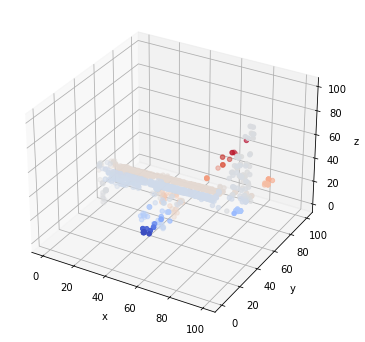

In [140]:
import matplotlib.pyplot as plt
from matplotlib import cm
from src import visual
visual.visual(example[0][0][1])

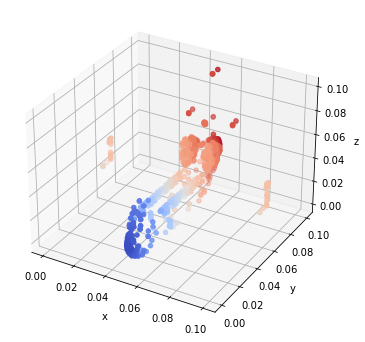

In [141]:
visual.visual(example[1]()[0][1])

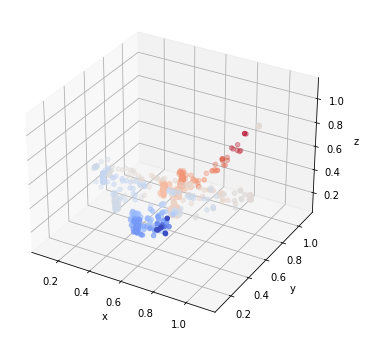

In [142]:
visual.visual(example[2]()[0][1])

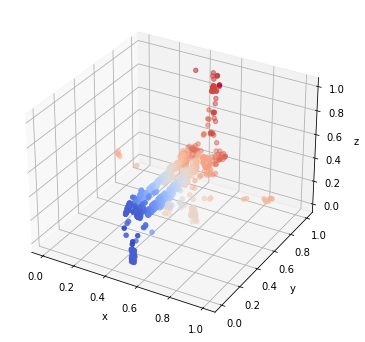

In [143]:
visual.visual(example[3]()[0][1])